In [3]:
#pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import lightgbm as lgbm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, average_precision_score, precision_score, precision_recall_curve, f1_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [5]:
# hyperparameter for lightgbm
param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 5000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [6]:
df = pd.read_csv("./creditcard.csv")
df.Class = df.Class.astype('category')
print(df.shape)
df.head(3)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [7]:
X = df.drop(['Class', 'Time'], axis=1)
y = df.Class
print(X.shape)
X.head(3)

(284807, 29)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66


In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [9]:
# random grid search over hyperparameter to save some time
lgbm_clf = lgbm.LGBMClassifier(random_state=0, silent=True, metric='none', n_jobs=-1)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=200,
    scoring='average_precision',
    cv=5,
    refit=True,
    random_state=0,
    verbose=True,
    n_jobs=-1)

grid_search.fit(X_train_smote, y_train_smote)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/liuy29/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/liuy29/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/liuy29/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/liuy

Best score reached: 0.9999966038481386 with params: {'colsample_bytree': 0.8043024059402862, 'learning_rate': 0.4, 'max_depth': 7, 'min_child_samples': 268, 'min_child_weight': 0.1, 'n_estimators': 600, 'num_leaves': 36, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.7672283681466321} 


In [12]:
# predict on test set
y_pred = grid_search.predict(X_test)

In [13]:
from sklearn.metrics import recall_score, average_precision_score, precision_score, precision_recall_curve, f1_score
# look at lightgbm prediction score
Recall = recall_score(y_test, y_pred, average = "binary")    
Precision = precision_score(y_test, y_pred, average = "binary")
F1score = f1_score(y_test, y_pred, average = "binary")  

print ('F1 score , Recall and Precision for Test dataset')
print ('Best F1 Score %f' %F1score)
print ('Best Recall Score %f' %Recall)
print ('Best Precision Score %f' %Precision)

F1 score , Recall and Precision for Test dataset
Best F1 Score 0.843750
Best Recall Score 0.826531
Best Precision Score 0.861702


In [14]:
auprc = average_precision_score(y_true=y_test, y_score=y_pred)
auprc

0.7125216317242858

In [15]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)

<AxesSubplot: >

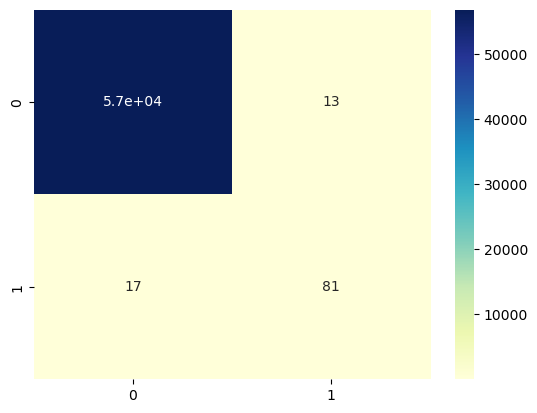

In [16]:
import seaborn as sns 
sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')